Đang chạy mô phỏng mô hình Hodgkin-Huxley...
Hoàn thành mô phỏng!


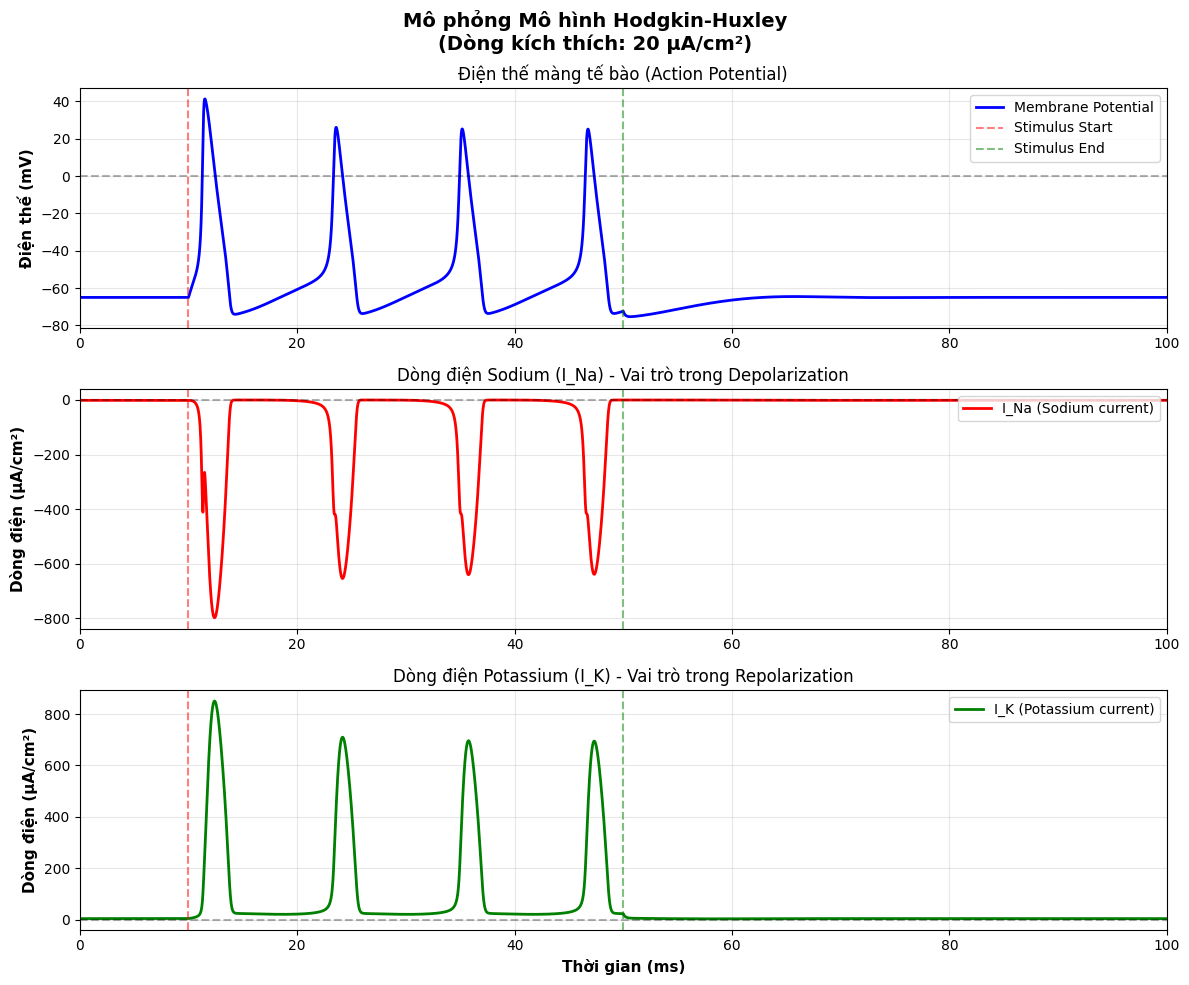


GIẢI THÍCH VAI TRÒ CỦA CÁC DÒNG ĐIỆN TRONG ACTION POTENTIAL

1. VAI TRÒ CỦA DÒNG SODIUM (I_Na) TRONG DEPOLARIZATION:
--------------------------------------------------------------------------------

- Khi có kích thích, các kênh Na+ mở (m tăng), cho phép ion Na+ tràn vào tế bào
- Dòng I_Na hướng VÀO (âm trong đồ thị) làm điện thế màng tăng nhanh (depolarization)
- Giai đoạn depolarization: V tăng từ -65mV lên đỉnh ~40mV
- Kênh Na+ có cơ chế inactivation (h giảm) nên đóng nhanh sau khi mở
- Đây là pha TĂNG nhanh của action potential (rising phase)


2. VAI TRÒ CỦA DÒNG POTASSIUM (I_K) TRONG REPOLARIZATION:
--------------------------------------------------------------------------------

- Kênh K+ mở chậm hơn (n tăng dần) so với kênh Na+
- Dòng I_K hướng RA (dương trong đồ thị) làm điện thế màng giảm (repolarization)
- Giai đoạn repolarization: V giảm từ đỉnh xuống về trạng thái nghỉ
- Kênh K+ đóng chậm nên có thể gây hyperpolarization (V < V_rest)
- Đây là pha GIẢM của action potential

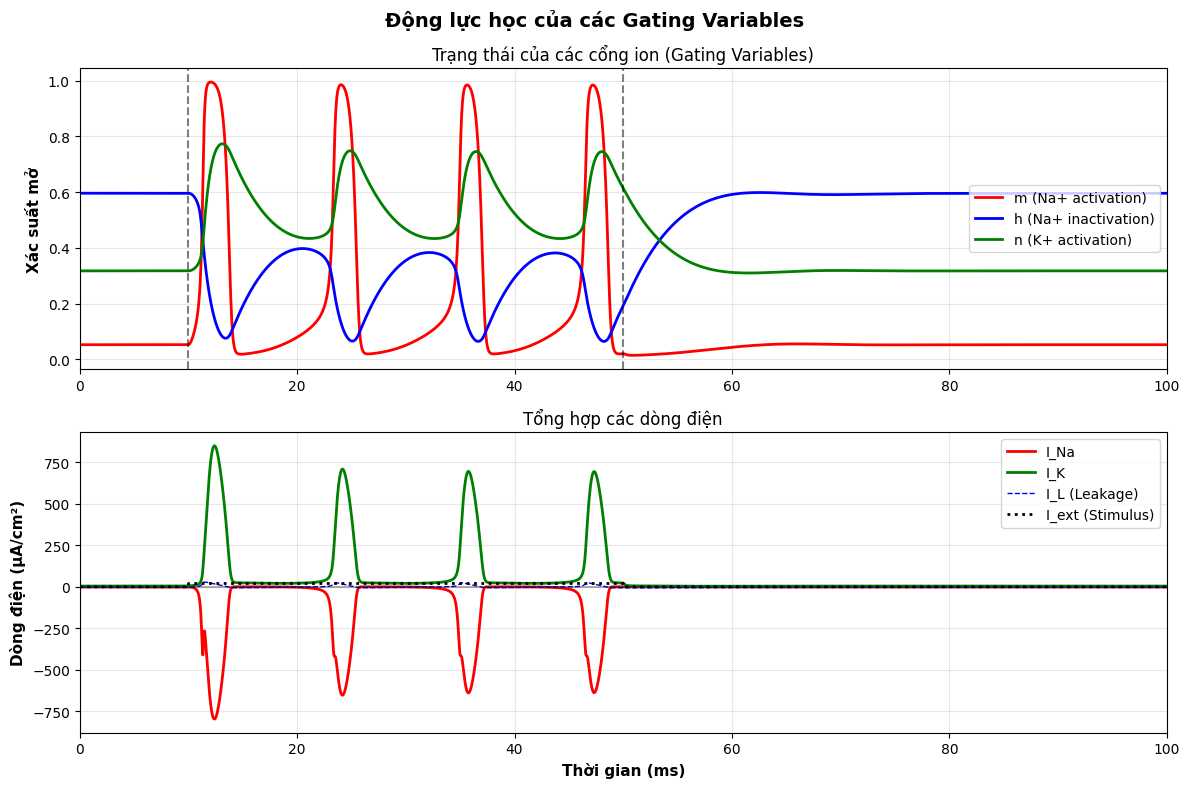

In [1]:
# File: hodgkin_huxley_simulation.ipynb
# Mô phỏng mô hình Hodgkin-Huxley cho Action Potential

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ============================================================================
# PHẦN 1: ĐỊNH NGHĨA CÁC THAM SỐ CỦA MÔ HÌNH HODGKIN-HUXLEY
# ============================================================================

# Tham số của màng tế bào
C_m = 1.0      # Điện dung màng (µF/cm²)
g_Na = 120.0   # Độ dẫn tối đa của kênh Sodium (mS/cm²)
g_K = 36.0     # Độ dẫn tối đa của kênh Potassium (mS/cm²)
g_L = 0.3      # Độ dẫn của dòng rò (mS/cm²)

# Điện thế đảo (reversal potentials)
E_Na = 50.0    # Điện thế đảo của Sodium (mV)
E_K = -77.0    # Điện thế đảo của Potassium (mV)
E_L = -54.387  # Điện thế đảo của dòng rò (mV)

# ============================================================================
# PHẦN 2: ĐỊNH NGHĨA CÁC HÀM TỐC ĐỘ (RATE FUNCTIONS) α_x và β_x
# ============================================================================

def alpha_m(V):
    """Hàm tốc độ mở của kênh m (activation gate của Na+)"""
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    """Hàm tốc độ đóng của kênh m"""
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    """Hàm tốc độ mở của kênh h (inactivation gate của Na+)"""
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    """Hàm tốc độ đóng của kênh h"""
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    """Hàm tốc độ mở của kênh n (activation gate của K+)"""
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    """Hàm tốc độ đóng của kênh n"""
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

# ============================================================================
# PHẦN 3: TÍNH DÒNG ĐIỆN CỦA CÁC KÊNH ION
# ============================================================================

def I_Na(V, m, h):
    """Dòng điện Sodium"""
    return g_Na * m**3 * h * (V - E_Na)

def I_K(V, n):
    """Dòng điện Potassium"""
    return g_K * n**4 * (V - E_K)

def I_L(V):
    """Dòng điện rò (Leakage)"""
    return g_L * (V - E_L)

# ============================================================================
# PHẦN 4: ĐỊNH NGHĨA DÒNG ĐIỆN ĐẦU VÀO (EXTERNAL CURRENT)
# ============================================================================

def I_ext(t, I_magnitude=20.0, t_start=10.0, t_end=50.0):
    """
    Dòng điện đầu vào dạng step input
    
    Parameters:
    - I_magnitude: Độ lớn dòng điện (µA/cm²) - theo đề bài là 20 µA/cm²
    - t_start: Thời điểm bắt đầu kích thích (ms)
    - t_end: Thời điểm kết thúc kích thích (ms)
    """
    if t_start <= t <= t_end:
        return I_magnitude
    else:
        return 0.0

# ============================================================================
# PHẦN 5: HỆ PHƯƠNG TRÌNH VI PHÂN CỦA MÔ HÌNH HODGKIN-HUXLEY
# ============================================================================

def hodgkin_huxley_derivatives(y, t, I_magnitude=20.0):
    """
    Hệ phương trình vi phân mô tả động lực học của mô hình HH
    
    y = [V, m, h, n]: vector trạng thái
    - V: điện thế màng (mV)
    - m: biến activation của kênh Na+
    - h: biến inactivation của kênh Na+
    - n: biến activation của kênh K+
    """
    V, m, h, n = y
    
    # Tính dòng điện đầu vào tại thời điểm t
    I_inj = I_ext(t, I_magnitude)
    
    # Phương trình điện thế màng (dV/dt)
    dVdt = (I_inj - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
    
    # Phương trình động lực học của các cổng ion (gating variables)
    dmdt = alpha_m(V) * (1.0 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1.0 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1.0 - n) - beta_n(V) * n
    
    return [dVdt, dmdt, dhdt, dndt]

# ============================================================================
# PHẦN 6: THIẾT LẬP ĐIỀU KIỆN BAN ĐẦU VÀ CHẠY MÔ PHỎNG
# ============================================================================

# Điện thế ban đầu (theo đề bài)
V0 = -65.0  # mV

# Tính trạng thái cân bằng của các gating variables tại V0
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))

# Vector trạng thái ban đầu
y0 = [V0, m0, h0, n0]

# Thiết lập thời gian mô phỏng
t_start = 0.0   # ms
t_end = 100.0   # ms
dt = 0.01       # bước thời gian (ms)
t = np.arange(t_start, t_end, dt)

# Chạy mô phỏng với dòng điện 20 µA/cm² (theo đề bài)
print("Đang chạy mô phỏng mô hình Hodgkin-Huxley...")
solution = odeint(hodgkin_huxley_derivatives, y0, t, args=(20.0,))

# Tách kết quả
V = solution[:, 0]
m = solution[:, 1]
h = solution[:, 2]
n = solution[:, 3]

# Tính các dòng điện
I_Na_values = np.array([I_Na(V[i], m[i], h[i]) for i in range(len(t))])
I_K_values = np.array([I_K(V[i], n[i]) for i in range(len(t))])
I_L_values = np.array([I_L(V[i]) for i in range(len(t))])

print("Hoàn thành mô phỏng!")

# ============================================================================
# PHẦN 7: VẼ BIỂU ĐỒ KẾT QUẢ
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Mô phỏng Mô hình Hodgkin-Huxley\n(Dòng kích thích: 20 µA/cm²)', 
             fontsize=14, fontweight='bold')

# Subplot 1: Điện thế màng (V)
axes[0].plot(t, V, 'b-', linewidth=2, label='Membrane Potential')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='Stimulus Start')
axes[0].axvline(x=50, color='g', linestyle='--', alpha=0.5, label='Stimulus End')
axes[0].set_ylabel('Điện thế (mV)', fontsize=11, fontweight='bold')
axes[0].set_title('Điện thế màng tế bào (Action Potential)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')
axes[0].set_xlim([0, 100])

# Subplot 2: Dòng điện Sodium (I_Na)
axes[1].plot(t, I_Na_values, 'r-', linewidth=2, label='I_Na (Sodium current)')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].axvline(x=10, color='r', linestyle='--', alpha=0.5)
axes[1].axvline(x=50, color='g', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Dòng điện (µA/cm²)', fontsize=11, fontweight='bold')
axes[1].set_title('Dòng điện Sodium (I_Na) - Vai trò trong Depolarization', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].set_xlim([0, 100])

# Subplot 3: Dòng điện Potassium (I_K)
axes[2].plot(t, I_K_values, 'g-', linewidth=2, label='I_K (Potassium current)')
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].axvline(x=10, color='r', linestyle='--', alpha=0.5)
axes[2].axvline(x=50, color='g', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Thời gian (ms)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Dòng điện (µA/cm²)', fontsize=11, fontweight='bold')
axes[2].set_title('Dòng điện Potassium (I_K) - Vai trò trong Repolarization', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right')
axes[2].set_xlim([0, 100])

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 8: GIẢI THÍCH VAI TRÒ CỦA I_Na VÀ I_K
# ============================================================================

print("\n" + "="*80)
print("GIẢI THÍCH VAI TRÒ CỦA CÁC DÒNG ĐIỆN TRONG ACTION POTENTIAL")
print("="*80)

print("\n1. VAI TRÒ CỦA DÒNG SODIUM (I_Na) TRONG DEPOLARIZATION:")
print("-" * 80)
print("""
- Khi có kích thích, các kênh Na+ mở (m tăng), cho phép ion Na+ tràn vào tế bào
- Dòng I_Na hướng VÀO (âm trong đồ thị) làm điện thế màng tăng nhanh (depolarization)
- Giai đoạn depolarization: V tăng từ -65mV lên đỉnh ~40mV
- Kênh Na+ có cơ chế inactivation (h giảm) nên đóng nhanh sau khi mở
- Đây là pha TĂNG nhanh của action potential (rising phase)
""")

print("\n2. VAI TRÒ CỦA DÒNG POTASSIUM (I_K) TRONG REPOLARIZATION:")
print("-" * 80)
print("""
- Kênh K+ mở chậm hơn (n tăng dần) so với kênh Na+
- Dòng I_K hướng RA (dương trong đồ thị) làm điện thế màng giảm (repolarization)
- Giai đoạn repolarization: V giảm từ đỉnh xuống về trạng thái nghỉ
- Kênh K+ đóng chậm nên có thể gây hyperpolarization (V < V_rest)
- Đây là pha GIẢM của action potential (falling phase)
""")

print("\n3. TƯƠNG TÁC GIỮA I_Na VÀ I_K:")
print("-" * 80)
print("""
- Ban đầu: I_Na chiếm ưu thế → Depolarization
- Sau đó: I_Na giảm (inactivation) và I_K tăng → Repolarization
- Sự cân bằng giữa hai dòng này tạo nên hình dạng đặc trưng của action potential
- Chu kỳ này lặp lại để truyền tín hiệu thần kinh
""")

print("\n" + "="*80)
print("KẾT THÚC MÔ PHỎNG")
print("="*80)

# ============================================================================
# PHẦN 9: PHÂN TÍCH BỔ SUNG - GATING VARIABLES
# ============================================================================

fig2, axes2 = plt.subplots(2, 1, figsize=(12, 8))
fig2.suptitle('Động lực học của các Gating Variables', fontsize=14, fontweight='bold')

# Gating variables
axes2[0].plot(t, m, 'r-', linewidth=2, label='m (Na+ activation)')
axes2[0].plot(t, h, 'b-', linewidth=2, label='h (Na+ inactivation)')
axes2[0].plot(t, n, 'g-', linewidth=2, label='n (K+ activation)')
axes2[0].axvline(x=10, color='k', linestyle='--', alpha=0.5)
axes2[0].axvline(x=50, color='k', linestyle='--', alpha=0.5)
axes2[0].set_ylabel('Xác suất mở', fontsize=11, fontweight='bold')
axes2[0].set_title('Trạng thái của các cổng ion (Gating Variables)', fontsize=12)
axes2[0].legend(loc='right')
axes2[0].grid(True, alpha=0.3)
axes2[0].set_xlim([0, 100])

# Tất cả dòng điện
axes2[1].plot(t, I_Na_values, 'r-', linewidth=2, label='I_Na')
axes2[1].plot(t, I_K_values, 'g-', linewidth=2, label='I_K')
axes2[1].plot(t, I_L_values, 'b--', linewidth=1, label='I_L (Leakage)')
axes2[1].plot(t, [I_ext(ti, 20.0) for ti in t], 'k:', linewidth=2, label='I_ext (Stimulus)')
axes2[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes2[1].set_xlabel('Thời gian (ms)', fontsize=11, fontweight='bold')
axes2[1].set_ylabel('Dòng điện (µA/cm²)', fontsize=11, fontweight='bold')
axes2[1].set_title('Tổng hợp các dòng điện', fontsize=12)
axes2[1].legend(loc='upper right')
axes2[1].grid(True, alpha=0.3)
axes2[1].set_xlim([0, 100])

plt.tight_layout()
plt.show()